# K Nearest Neighbours (KNN)

**The prediction task**: 
To predict which mobile phones can be soled for a high price.

**The rationale**: 
Help a company determine its price policy. More precisely, help it identify which phones it can offer to its customers on a high price.

**Type of task**: 
Binary classification 

**Algorithm to be used**: 
K Nearest Neighbours (kNN)

### Load the required libraries

In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

from classification_util import *

### Load and inspect the data

The data originates from the [Mobile Price Classification dataset](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification), where further information about it can be found (including the description of all the variables).

Note: The original data set has been adapted (simplified) for this class.

In [2]:
data = pd.read_csv(Path.cwd().parent / 'data' / 'mobiles.csv')
data.head(10)

,battery_power,clock_speed,dual_sim,fc,int_memory,m_dep,mobile_wt,n_cores,pc,ram,sc_h,sc_w,talk_time,price_range
0,842,2.2,0,1,7,0.6,188,2,2,2549,9,7,19,1
1,1021,0.5,1,0,53,0.7,136,3,6,2631,17,3,7,2
2,563,0.5,1,2,41,0.9,145,5,6,2603,11,2,9,2
3,615,2.5,0,0,10,0.8,131,6,9,2769,16,8,11,2
4,1821,1.2,0,13,44,0.6,141,2,14,1411,8,2,15,1
5,1859,0.5,1,3,22,0.7,164,1,7,1067,17,1,10,1
6,1821,1.7,0,4,10,0.8,139,8,10,3220,13,8,18,3
7,1954,0.5,1,0,24,0.8,187,4,0,700,16,3,5,0
8,1445,0.5,0,0,53,0.7,174,7,14,1099,17,1,20,0
9,509,0.6,1,2,9,0.1,93,5,15,513,19,10,12,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   clock_speed    2000 non-null   float64
 2   dual_sim       2000 non-null   int64  
 3   fc             2000 non-null   int64  
 4   int_memory     2000 non-null   int64  
 5   m_dep          2000 non-null   float64
 6   mobile_wt      2000 non-null   int64  
 7   n_cores        2000 non-null   int64  
 8   pc             2000 non-null   int64  
 9   ram            2000 non-null   int64  
 10  sc_h           2000 non-null   int64  
 11  sc_w           2000 non-null   int64  
 12  talk_time      2000 non-null   int64  
 13  price_range    2000 non-null   int64  
dtypes: float64(2), int64(12)
memory usage: 218.9 KB


We will use the `price_range` variable to create the outcome variable:

In [4]:
data.price_range.value_counts()

price_range
1    500
2    500
3    500
0    500
Name: count, dtype: int64

Create the outcome variable - `top_price` - by considering that `price_range` value of 3 denotes top price:

In [5]:
data['top_price'] = data.price_range.apply(lambda pr: "Yes" if pr == 3 else "No")
data.top_price.value_counts()

top_price
No     1500
Yes     500
Name: count, dtype: int64

Remove from the data set the variable used for creating the outcome variable:

In [6]:
data.drop(columns='price_range', inplace=True)

We can also separate the input and output variables, to facilitate the next steps 

In [7]:
X = data.drop(columns='top_price')
y = data.top_price

### Data preparation

kNN algorithm typically works with numerical data. It can be used with categorical data, as well, but in that case it requires a distance measure that is appropriate for categorical data, such as [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance). Such a use of the kNN algorithm is out of scope of this course.

In the current data set, all input variables are numerical variables (either whole or real value numbers). As such, they can be used for model building.
Note: the dual_sim variable is not a true numeric variable; it is an indicator variable, indicating if a phone supports two sim cards or not. Such variables are often treated as numeric and used in kNN with other numeric variables.  

If we had an ordinal variables encoded as a factor - for example, satisfaction of customers w/ the phone, expressed on a 5-point scale from Not All to Fully Satisfied - we could transform it into an int variable and use it for model building.

On the other hand, if we had a true categorical variable encoded as a factor - for example, the color of the phone - we would not use it. As noted above, it is generally possible, but is more complicated and we will not consider such cases.

To find nearest neighbours for any new observation, we need to compute distance between that observation and the observations in our training set. Often used distance (or similarity) measures, such as the *Euclidean distance*, are very sensitive to the value range of variables: variables with wide value ranges tend to dominate over those with narrower ranges. In other words, the computed distances are overly affected by variables with wider value ranges. Therefore, we need to check the value range of the input variables and if their value ranges differ significantly, we should scale the input variables.

#### Scaling of the input variables

The purpose of scaling is to change the value range of variables, so that all variables have the same or at least similar value range. Frequently used approaches for scaling variables are:
* ***Min-Max Scaling***, which reduces variables to the same value range (typically 0-1). Its key advantage is that all variables have the same value range. However, it should not be used in the presence of outliers
* ***Standardisation***, which reduces the difference in value ranges by rescaling variables to have the mean of 0 and standard deviation of 1. Like min-max scaling, standardisation should not be used in the presence of outliers; also, should not be used in case of variables that are not normally distributed. 
* ***Robust standardisation***, which reduces the difference in value ranges by rescaling data to have the median of 0 and interquartile range (IQR) of 1. It should be used in the presence of outliers or as an alternative to (regular) standardisation when a variable is not normally distributed.

When possible, the use of min-max scaling is preferred scaling approach as it ensures that all variables have the same value range. However, if outliers are present, robust standardisation should be used instead. In the latter case, the transformed variables will not have the same value range, but the difference will be reduced.

So, let’s check if the input variables have outliers. This is often done using [boxplot](https://builtin.com/data-science/boxplot). For example, we can use a boxplot to check the presence of outliers in the `battery_power` attribute:

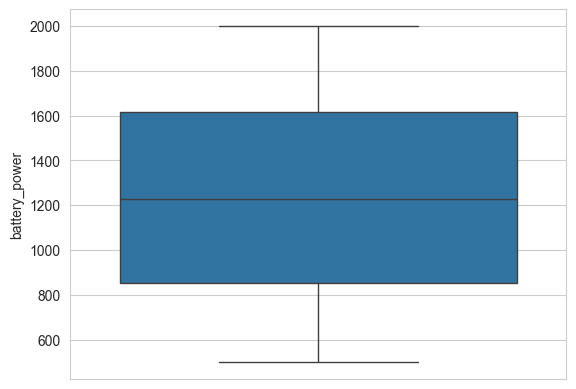

In [8]:
sb.boxplot(X.battery_power);

We can be more efficient by using a function that checks for each variable if it contains outliers or not. 

The following function identifies and returns a list of outliers (empty if no outliers). In line with the above boxplot-based approach, the function identifies outliers as values that are above `Q3 + 1.5*IQR` or below `Q1 - 1.5*IQR`, where IQR is interquartile range and Q1 and Q3 are the first and the third quartile, respectively.  

In [9]:
def get_outliers(variable):
    from statistics import quantiles
    
    Q1, _, Q3 = quantiles(variable)
    IQR = Q3 - Q1
    upper = Q3 + 1.5*IQR
    lower = Q1 - 1.5*IQR
    return [val for val in variable if val < lower or val > upper]

In [10]:
print("Number of outliers in the input variables")
for col in X.columns:
    col_out = get_outliers(X[col].tolist())
    n_out = len(col_out)
    print(f"Variable {col.upper()}: {'None' if n_out == 0 else n_out}")
    

Number of outliers in the input variables
Variable BATTERY_POWER: None
Variable CLOCK_SPEED: None
Variable DUAL_SIM: None
Variable FC: None
Variable INT_MEMORY: None
Variable M_DEP: None
Variable MOBILE_WT: None
Variable N_CORES: None
Variable PC: None
Variable RAM: None
Variable SC_H: None
Variable SC_W: None
Variable TALK_TIME: None


None of the input variables have outliers => we can do min-max scaling

In [11]:
# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(X)
X_scaled = pd.DataFrame(data=scaled_data, columns=X.columns)

Check that the value ranges are really the same:

In [12]:
X_scaled.describe()

,battery_power,clock_speed,dual_sim,fc,int_memory,m_dep,mobile_wt,n_cores,pc,ram,sc_h,sc_w,talk_time
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.492664,0.408900,0.509500,0.268375,0.484621,0.446389,0.502075,0.502929,0.495825,0.499255,0.521893,0.320389,0.500611
std,0.293533,0.326402,0.500035,0.268501,0.292673,0.320462,0.294997,0.326834,0.303216,0.289880,0.300946,0.242022,0.303553
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.234302,0.080000,0.000000,0.062500,0.225806,0.111111,0.241667,0.285714,0.250000,0.254276,0.285714,0.111111,0.222222
50%,0.484302,0.400000,1.000000,0.187500,0.483871,0.444444,0.508333,0.428571,0.500000,0.505211,0.500000,0.277778,0.500000
75%,0.744322,0.680000,1.000000,0.437500,0.741935,0.777778,0.750000,0.857143,0.750000,0.750534,0.785714,0.500000,0.777778
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can now proceed to split the data into training and test sets and build models.

### Train-test split

We split the data into training and test sets in the same way we did before, using 80% of the data for the training set.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    shuffle=True,
                                                    stratify=y)

Check if the distribution of the outcome variable in the train and test sets is the same:

In [14]:
y_train.value_counts(normalize=True)

top_price
No     0.75
Yes    0.25
Name: proportion, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

top_price
No     0.75
Yes    0.25
Name: proportion, dtype: float64

### Initial knn classification

We will first do the classification with a randomly chosen value for k.

In [16]:
from random import randrange, seed

seed(1)
rand_k = randrange(3, 21, 2) ## reminder: we consider only odd values for k, to avoid ties
print(f"randomly selected k: {rand_k}")

knn1 = KNeighborsClassifier(n_neighbors = rand_k).fit(X_train,y_train)
knn1_pred = knn1.predict(X_test)

randomly selected k: 7


We will now create the confusion matrix and compute the evaluation measures:

In [17]:
cm1 = confusion_matrix(y_test, knn1_pred)

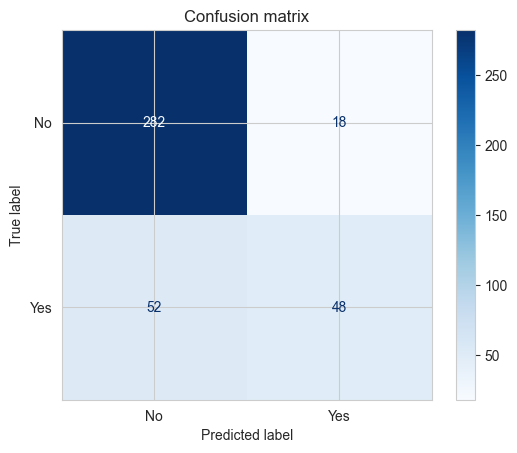

In [18]:
plot_confusion_matrix(cm1, knn1.classes_)

In [19]:
knn1_eval = compute_basic_eval_measures(cm1, 'knn_1')
knn1_eval

accuracy     0.825000
precision    0.727273
recall       0.480000
F1           0.578313
Name: knn_1, dtype: float64

In [20]:
# We can get more detailed model evaluation report with the classification_report method
print(classification_report(y_test, knn1_pred))

              precision    recall  f1-score   support

          No       0.84      0.94      0.89       300
         Yes       0.73      0.48      0.58       100

    accuracy                           0.82       400
   macro avg       0.79      0.71      0.73       400
weighted avg       0.82      0.82      0.81       400



### Hyperparameter tuning through cross-validation

There are a couple of things that may affect the performance of a kNN-based classifier:

* the value of k, that is, the number of nearest neighbours to consider
* the measure used to compute distance (similarity) to neighbours
* the use of weights to assign distinct relevance to neighbours; in particular, we may consider all neighbors as equally important or consider those that are closer as more important (in which case they are assigned higher weight)
 
We will try to improve the results by finding an optimal combination of these hyperparameters through n-fold cross-validation (CV).

To that end, we will use the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class from `sklearn.model_selection` module. It allows for exhaustive grid search over several hyperparameters in order to find an optimal combination of their values. It tries every possible combination of the hyperparameter values and does so through CV process, thus ensuring lower variability of the estimated performance (that is, higher trust in the results). This approach is a good way to determine the best hyperparameter values when there are not many hyperparameters to consider and not many values to consider for each one of them.

We will run CV-ed grid search over three hyperparameters:
* n_neighbors: odd numbers between 3 and 21
* weights: 'uniform' (assigns no weight) and 'distance' (weighs observations by the inverse of their distances)
* metric: 'manhattan' and 'euclidean'

As the scoring function - the metric we use to estimate the model performance - we will use balanced accuracy, due to the lack of balance in the dataset (= uneven distribution of the two classes in the dataset).   

In [21]:
grid_params = { 'n_neighbors' : range(3, 21, 2),
                'weights' : ['uniform','distance'],
                'metric' : ['euclidean','manhattan']}

seed(1)
grid_search = GridSearchCV(KNeighborsClassifier(), 
                           grid_params,
                           cv=10, # 10-fold CV
                           scoring='f1', # F1 measure
                           verbose = 1, # controls the verbosity of the execution log
                           n_jobs = -1) # make use of all the processors

In [22]:
# the method for computing F1 expects the output variable to be numeric (0,1)
y_train_bin = [1 if val=="Yes" else 0 for val in y_train]

In [23]:
# fit the model on the train set
g_res = grid_search.fit(X_train, y_train_bin)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


In [24]:
# get the hyperparameter combination with the best score
print(g_res.best_params_)
# and the best balanced accuracy score
print(f"F1={g_res.best_score_:.4f}")

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
F1=0.6620


If interested in examining model performance for all hyperparamter combinations:

In [25]:
pd.DataFrame.from_dict(g_res.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001975,0.000623,0.011916,0.008057,euclidean,3,uniform,"{'metric': 'euclidean', 'n_neighbors': 3, 'wei...",0.539683,0.579710,...,0.567164,0.658228,0.611111,0.529412,0.743590,0.621622,0.694444,0.609291,0.067436,31
1,0.002824,0.001625,0.005896,0.003939,euclidean,3,distance,"{'metric': 'euclidean', 'n_neighbors': 3, 'wei...",0.539683,0.579710,...,0.567164,0.658228,0.611111,0.529412,0.743590,0.621622,0.694444,0.609291,0.067436,31
2,0.002230,0.000794,0.008850,0.003248,euclidean,5,uniform,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.557377,0.637681,...,0.603175,0.608696,0.608696,0.586667,0.702703,0.647887,0.753623,0.622958,0.063768,25
3,0.001994,0.000692,0.003817,0.001307,euclidean,5,distance,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.557377,0.637681,...,0.603175,0.600000,0.608696,0.586667,0.702703,0.647887,0.753623,0.622089,0.064015,26
4,0.001740,0.000516,0.008196,0.003194,euclidean,7,uniform,"{'metric': 'euclidean', 'n_neighbors': 7, 'wei...",0.533333,0.617647,...,0.610169,0.646154,0.666667,0.597015,0.732394,0.705882,0.696970,0.629010,0.073929,18
5,0.001712,0.000554,0.004140,0.001577,euclidean,7,distance,"{'metric': 'euclidean', 'n_neighbors': 7, 'wei...",0.533333,0.617647,...,0.610169,0.646154,0.666667,0.597015,0.732394,0.705882,0.696970,0.629010,0.073929,18
6,0.001644,0.000560,0.007162,0.002663,euclidean,9,uniform,"{'metric': 'euclidean', 'n_neighbors': 9, 'wei...",0.491228,0.593750,...,0.677419,0.566667,0.636364,0.646154,0.685714,0.676923,0.716418,0.623301,0.068656,24
7,0.001428,0.000642,0.004411,0.001087,euclidean,9,distance,"{'metric': 'euclidean', 'n_neighbors': 9, 'wei...",0.491228,0.593750,...,0.677419,0.590164,0.636364,0.646154,0.685714,0.676923,0.716418,0.625651,0.067061,21
8,0.001759,0.001134,0.007601,0.003085,euclidean,11,uniform,"{'metric': 'euclidean', 'n_neighbors': 11, 'we...",0.566667,0.593750,...,0.709677,0.610169,0.646154,0.580645,0.676471,0.625000,0.746269,0.637775,0.054692,15
9,0.001142,0.000514,0.004847,0.002047,euclidean,11,distance,"{'metric': 'euclidean', 'n_neighbors': 11, 'we...",0.566667,0.593750,...,0.709677,0.622951,0.646154,0.580645,0.676471,0.625000,0.746269,0.639053,0.054179,13


Now, we create a model with the optimal hyperparameter combination: 

In [26]:
# use the best hyperparameters
best_k = g_res.best_params_['n_neighbors']
best_metric = g_res.best_params_['metric']
best_weights = g_res.best_params_['weights']

knn2 = KNeighborsClassifier(n_neighbors = best_k, weights = best_weights, metric = best_metric)
knn2.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=11, weights='distance')

Next, we make predictions and evaluate the model

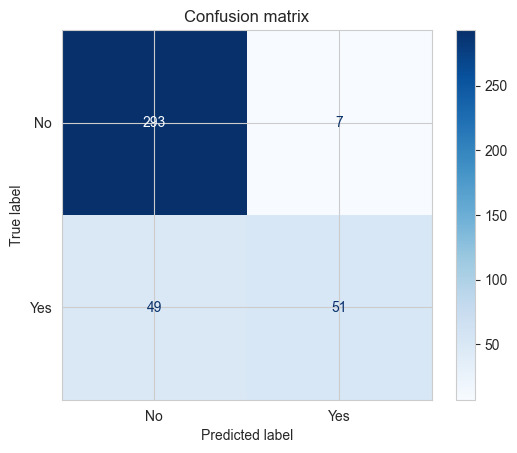

In [27]:
knn2_pred = knn2.predict(X_test)

cm2 = confusion_matrix(y_test, knn2_pred)
plot_confusion_matrix(cm2, knn2.classes_)

In [28]:
knn2_eval = compute_basic_eval_measures(cm2, 'knn_2')
knn2_eval

accuracy     0.86000
precision    0.87931
recall       0.51000
F1           0.64557
Name: knn_2, dtype: float64

Compare the results with the initial model (random k selection, no weights, Eucledian distance)

In [29]:
pd.concat([knn1_eval, knn2_eval], axis=1)

,knn_1,knn_2
accuracy,0.825000,0.86000
precision,0.727273,0.87931
recall,0.480000,0.51000
F1,0.578313,0.64557


The 2nd model is, as expected, better than the first one along all the evaluation measures.

### Final notes

* Improper selection of K may lead to under-fitting or over-fitting. in general, very low k values tend to lead to high variance and over-fitting, whereas very high k values tend to lead to high bias and under-fitting. A nice explanation is given in [this video](https://www.youtube.com/watch?v=X_3Ke5zVqo4).

* To learn more about distance measures often used in kNN and how to select which one to use (consider), [this short video](https://www.youtube.com/watch?v=_EEcjn0Uirw) might be useful.